In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

pd.set_option('display.max.rows', 130)
pd.set_option('display.max.columns', 130)
pd.set_option('float_format', '{:.2f}'.format)
np.set_printoptions(legacy='1.25')

In [ ]:
#!pip install hyperopt

In [41]:
from bank_term_deposit_functions import (split_data, create_inputs_targets, evaluate_model, evaluate_predictions)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Load Data

In [4]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/bank-additional-processed.csv')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


###Split Data

In [6]:
splitted_data = split_data(df, 'y')
train_df, val_df = splitted_data['train'], splitted_data['val']

In [7]:
train_df.shape, val_df.shape

((32940, 21), (8236, 21))

In [8]:
input_cols = list(df.drop(columns=['duration', 'y']).columns)
target_col = 'y'

In [9]:
inputs_targets_data = create_inputs_targets(splitted_data, input_cols, target_col)

In [10]:
train_inputs, train_targets = inputs_targets_data['train_inputs'], inputs_targets_data['train_targets']
val_inputs, val_targets = inputs_targets_data['val_inputs'], inputs_targets_data['val_targets']

In [11]:
train_inputs.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
36444,24,technician,single,professional.course,no,no,no,cellular,jun,tue,2,999,1,failure,-2.90,92.96,-40.80,1.26,5076.20


###Identify numeric and categorical columns

In [12]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.to_list()
categorical_cols = train_inputs.select_dtypes(include='object').columns.to_list()

In [13]:
print(numeric_cols)
print(categorical_cols)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


###Preprocessing Pipelines

In [14]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_cat = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols)
])

preprocessor_num_cat = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [15]:
preprocessor_cat.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

###Comparing Models

* LogisticRegression
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* XGBClassifier
* LGBMClassifier

Evaluation Metric - AUC-ROC Score with Stratified k-fold cross-validation as the primary metric to ensure a balanced assessment across unbalanced target.

In [16]:
log_reg = LogisticRegression(random_state=42, solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=10)
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
rnd_forest_tree = RandomForestClassifier(max_depth=5, random_state=42)

xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.1,
                    n_estimators=30,
                    random_state=42)

lgb = LGBMClassifier(max_depth=6,
                     learning_rate=0.03,
                     n_estimators=50,
                     random_state=42,
                     verbose=-1)

In [17]:
results = []

for model in [log_reg, knn]:
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_num_cat),
        ('classifier', model)
    ])
    model_pipeline.fit(train_inputs, train_targets)
    eval_results  = evaluate_model(model_pipeline, train_inputs, train_targets, val_inputs, val_targets)
    results.append({
        'Model name': str(model).split('(')[0],
        'Parameters': str(model).split('(')[1].rsplit(')')[0],
        **eval_results
    })

for model in [dec_tree, rnd_forest_tree, xgb, lgb]:
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_cat),
        ('classifier', model)
    ])
    model_pipeline.fit(train_inputs, train_targets)
    eval_results  = evaluate_model(model_pipeline, train_inputs, train_targets, val_inputs, val_targets)
    results.append({
        'Model name': str(model).split('(')[0],
        'Parameters': str(model).split('(')[1].rsplit(')')[0],
        **eval_results
    })

In [18]:
with pd.option_context("display.max_colwidth", None,
                       "display.width", None):
    display(pd.DataFrame(results))

,Model name,Parameters,Train AUROC,Validation AUROC
0,LogisticRegression,"random_state=42, solver='liblinear'",0.79,0.80
1,KNeighborsClassifier,n_neighbors=10,0.89,0.75
2,DecisionTreeClassifier,"max_depth=5, random_state=42",0.72,0.71
3,RandomForestClassifier,"max_depth=5, random_state=42",0.76,0.76
4,XGBClassifier,"base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=0.1, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=30,\n n_jobs=None, num_parallel_tree=None, ...",0.78,0.77
5,LGBMClassifier,"learning_rate=0.03, max_depth=6, n_estimators=50,\n random_state=42, verbose=-1",0.77,0.77


Models Analysis:
1. `LogisticRegression` - performs well on train and validation datasets (0.79 → 0.80). Good model with its simplicity, interpretability, and robustness.
2. `KNeighborsClassifier` - big gap between results for train and validation data (0.89 → 0.75), it shows high overfitting. Model struggles to generalize to unseen data, possibly due to sensitivity to noise and feature scaling.
3. `DecisionTreeClassifier` - Underfit but stable (0.72 → 0.71). Small gap, modest accuracy. Single trees lack capacity and are high-variance; keep as a didactic baseline, not a contender.
4. `RandomForestClassifier` - Balanced, slightly below LR (0.76 → 0.76). Good generalization, but current setup is conservative.
5. `XGBClassifier` - Competitive, slightly underfit (0.78 → 0.77). Can be improved with hyperparameters tuning.
6. `LGBMClassifier` - Showed good result for both train and validation data. Can be improved with hyperparameters tuning.

            
Next Steps:   
1. Hyperparameter tuning: tune XGB and LGBM for possible performance gains.
2. Feature engineering: Investigate feature importance to refine model input.

###Hyperparameters Tuning

####RandomizedSearchCV for XGBoostClassifier

In [19]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=30, random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('xgb', xgb)
])

params_xgb = {
    'xgb__n_estimators': np.arange(50, 500, 25),
    'xgb__learning_rate': np.arange(0.01, 1, 0.05),
    'xgb__max_depth': np.arange(2, 20, 1),
    'xgb__min_child_weight': np.arange(1, 30, 1),
    'xgb__gamma': np.arange(0, 10, 1),
    'xgb__subsample': np.linspace(0.6, 1.0, 9),
    'xgb__colsample_bytree': np.linspace(0.6, 1.0, 9),
    'xgb__reg_alpha': np.logspace(-8, 1, 15),
    'xgb__reg_lambda': np.logspace(-8, 1, 15),
    'xgb__max_bin': np.arange(128, 512, 16),
}

randomized_xgb = RandomizedSearchCV(model_pipeline, params_xgb, n_iter=40, cv=3, scoring='roc_auc')
randomized_xgb.fit(train_inputs, train_targets)
xgb_random_search_best = randomized_xgb.best_estimator_

display(randomized_xgb.best_params_)
print('')
result = evaluate_model(xgb_random_search_best, train_inputs, train_targets, val_inputs, val_targets, True)

{'xgb__subsample': 0.85,
 'xgb__reg_lambda': 0.026826957952797274,
 'xgb__reg_alpha': 7.196856730011529e-05,
 'xgb__n_estimators': 75,
 'xgb__min_child_weight': 25,
 'xgb__max_depth': 16,
 'xgb__max_bin': 352,
 'xgb__learning_rate': 0.11,
 'xgb__gamma': 8,
 'xgb__colsample_bytree': 0.9}


AUROC for train:      0.77
AUROC for validation: 0.77


####Hyperopt for XGBoostClassifier

In [21]:
space = {
    "n_estimators":      hp.quniform("n_estimators", 50, 500, 25),
    "learning_rate":     hp.loguniform("learning_rate", np.log(1e-3), np.log(3e-1)),
    "max_depth":         hp.quniform("max_depth", 2, 16, 1),
    "min_child_weight":  hp.quniform("min_child_weight", 1, 15, 1),
    "gamma":             hp.uniform("gamma", 0.0, 10.0),
    "subsample":         hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree":  hp.uniform("colsample_bytree", 0.6, 1.0),
    "reg_alpha":         hp.loguniform("reg_alpha", np.log(1e-8), np.log(10)),
    "reg_lambda":        hp.loguniform("reg_lambda", np.log(1e-8), np.log(10)),
    "max_bin":           hp.quniform("max_bin", 128, 512, 16),  # needs tree_method="hist"
}

def objective(params):
    # cast ints
    for k in ["n_estimators", "max_depth", "min_child_weight", "max_bin"]:
        params[k] = int(params[k])

    clf = XGBClassifier(
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="auc",
        objective="binary:logistic",
        verbosity=0,
        **params,
    )

    model = Pipeline([("preprocessor", preprocessor_cat), ("clf", clf)])
    auroc = cross_val_score(model, train_inputs, train_targets, scoring="roc_auc", cv=3, n_jobs=-1)
    return { "loss": -auroc.mean(), "status": STATUS_OK }

trials = Trials()
best_idxs = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20,
                 trials=trials, rstate=np.random.default_rng(42))

best_params = space_eval(space, best_idxs)
for k in ["n_estimators", "max_depth", "min_child_weight", "max_bin"]:
    best_params[k] = int(best_params[k])

final_clf = Pipeline([
    ("preprocessor", preprocessor_cat),
    ("clf", XGBClassifier(
        random_state=42, n_jobs=-1, tree_method="hist", eval_metric="auc",
        objective="binary:logistic", verbosity=0, **best_params
    )),
])

final_clf.fit(train_inputs, train_targets)

100%|██████████| 20/20 [01:04<00:00,  3.20s/trial, best loss: -0.7687161920699072]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None...
                               gamma=4.42579530761786, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.010509599317067317, max_bin=352,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [22]:
display('Найкращі гіперпараметри: ', best_params)
print('')
result = evaluate_model(final_clf, train_inputs, train_targets, val_inputs, val_targets, True)

'Найкращі гіперпараметри: '

{'colsample_bytree': 0.9260307872455835,
 'gamma': 4.42579530761786,
 'learning_rate': 0.010509599317067317,
 'max_bin': 352,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 500,
 'reg_alpha': 1.425181609294266e-08,
 'reg_lambda': 1.4177012448628423,
 'subsample': 0.6929842549878388}


AUROC for train:      0.78
AUROC for validation: 0.77


####Hyperopt for LGBMClassifier

In [23]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

def objective(params):
    for k in ["n_estimators", "max_depth", "num_leaves", "min_child_weight"]:
        params[k] = int(params[k])

    lgb_clf = LGBMClassifier(**params)

    model = Pipeline([("preprocessor", preprocessor_cat), ("clf", lgb_clf)])
    auroc = cross_val_score(model, train_inputs, train_targets, scoring="roc_auc", cv=3, n_jobs=-1)
    return { "loss": -auroc.mean(), "status": STATUS_OK }

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
best_params = space_eval(space, best)
for k in ["n_estimators", "max_depth", "num_leaves", "min_child_weight"]:
    best_params[k] = int(best_params[k])

final_lgb_clf = Pipeline([
    ("preprocessor", preprocessor_cat),
    ("clf", LGBMClassifier(**best_params)),
])

final_lgb_clf.fit(train_inputs, train_targets)

100%|██████████| 20/20 [00:40<00:00,  2.02s/trial, best loss: -0.767446066689451]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.7433976876080384,
                                learning_rate=0.13142130154300488, max_depth=11,
                                min_child_weight=6,
                                min_split_gain=0.07281198973190627,
                                n_estimators=450, num_leaves=44,
                                reg_alpha=0.4395576565114945,
                                reg_lambda=0.20688968953656994,
                                subsample=0.8486459168764364))])

In [24]:
display('Найкращі гіперпараметри: ', best_params)
print('')
result = evaluate_model(final_lgb_clf, train_inputs, train_targets, val_inputs, val_targets, True)

'Найкращі гіперпараметри: '

{'colsample_bytree': 0.7433976876080384,
 'learning_rate': 0.13142130154300488,
 'max_depth': 11,
 'min_child_weight': 6,
 'min_split_gain': 0.07281198973190627,
 'n_estimators': 450,
 'num_leaves': 44,
 'reg_alpha': 0.4395576565114945,
 'reg_lambda': 0.20688968953656994,
 'subsample': 0.8486459168764364}


AUROC for train:      0.79
AUROC for validation: 0.77


After hyperopt tuning `LGBM` showed better results.

In [26]:
bank_deposit_prediction = {
    'clf': LGBMClassifier(**best_params),
    'preprocessor_cat': preprocessor_cat,
    'final_lgb_clf': final_lgb_clf
}

joblib.dump(bank_deposit_prediction, './model_lgb_best.joblib')

['./model_lgb_best.joblib']

###Feature Importance for LGBMClassifier

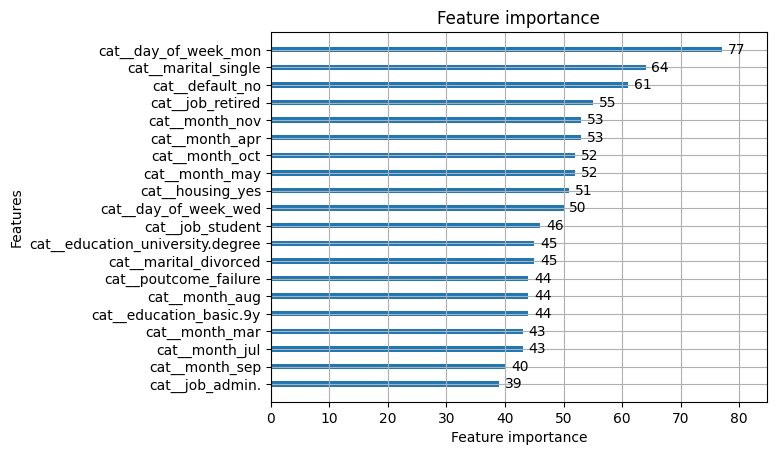

In [27]:
plot_importance(final_lgb_clf.named_steps["clf"], height=0.3, max_num_features=20)
plt.show()

Top features:

1. day_of_week = Monday (cat__day_of_week_mon, 77) — strongest single signal; timing of contact matters.
2. marital = single (cat__marital_single, 64) — customer status differentiates responses.
3. default = no (cat__default_no, 61) — credit risk proxy; those without recorded default behave differently.
4. job = retired (cat__job_retired, 55) — segment with distinct response patterns.
5. month = Nov/Apr/Oct/May (cat__month_nov/apr/oct/may, 55/53/53/52) — strong seasonality in success rates.
6. housing = yes (cat__housing_yes, 51) — mortgage ownership correlates with outcome.
7. day_of_week = Wed (cat__day_of_week_wed, 50) — more timing signal.
8. job = student (cat__job_student, 46) — distinct engagement relative to other jobs.
9. education = university.degree (cat__education_university.degree, 45) — education level influences likelihood to respond.
10. marital = divorced (cat__marital_divorced, 45) — demographic differentiation.
11. poutcome = failure (cat__poutcome_failure, 44) — past campaign outcome is predictive for future contact.
12. Additional month dummies (Aug/Mar/Jul/Sep, 44/43/43/40) and job = admin. (39) continue the same themes.

Conclusion:    

Calendar effects dominate. Many of the top slots are month and day-of-week dummies. Response rates are highly time-dependent; planning/targeting by when you contact customers is likely to yield material gains.

Customer profile matters. Marital status, job (retired/student/admin), and education appear repeatedly—behavior differs across these segments.

Credit/financial proxies matter. default_no and housing_yes suggest that basic credit risk and mortgage status are informative.

History matters. poutcome_failure shows that prior campaign results carry signal for the next contact.

###Shap analysis

In [28]:
val_inputs_transform = final_lgb_clf.named_steps["preprocessor"].transform(val_inputs)

explainer = shap.TreeExplainer(final_lgb_clf.named_steps["clf"])
shap_values = explainer(val_inputs_transform)

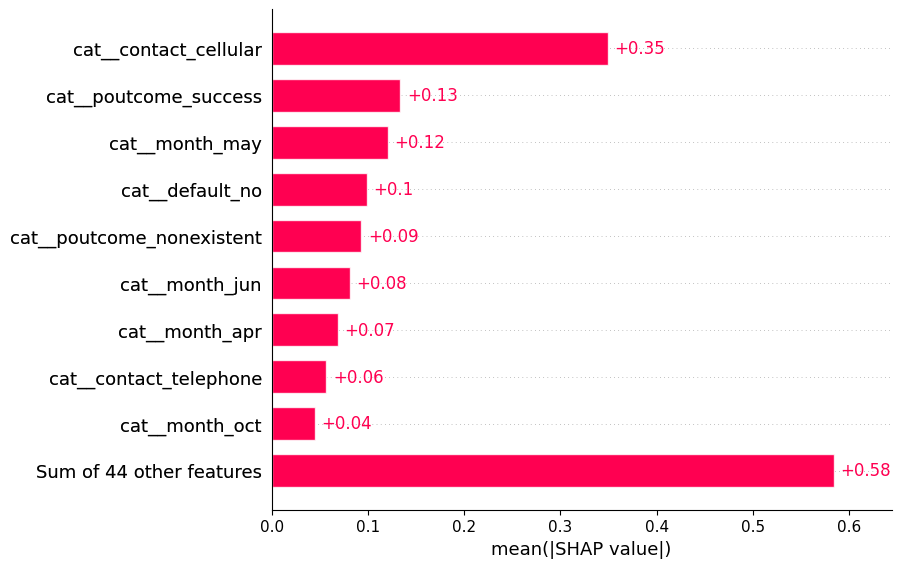

In [29]:
shap.plots.bar(shap_values)

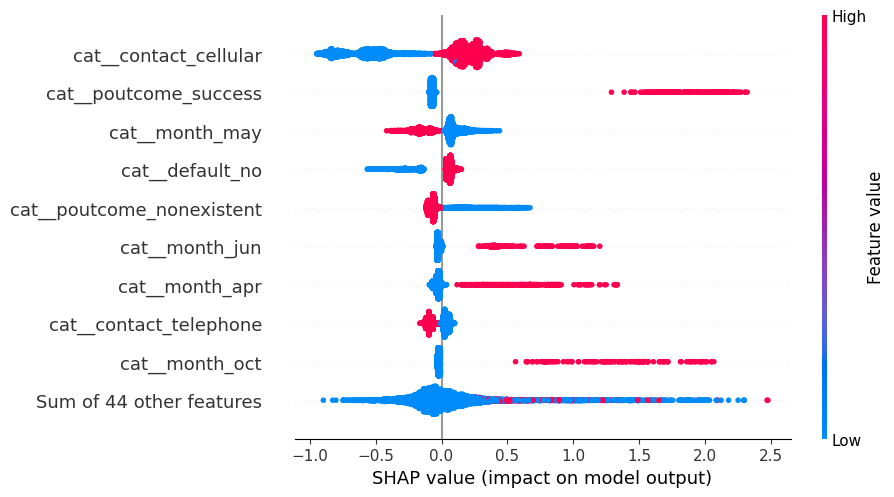

In [30]:
shap.plots.beeswarm(shap_values)

Top drivers (direction & strength):

* contact_cellular — largest positive effect. When the contact channel is cellular, SHAP values are strongly > 0 → probability of a positive outcome rises.
Implication: prioritize cellular outreach.

* poutcome_success — strong positive. Prior success in a previous campaign pushes predictions up a lot.
Implication: re-engage customers with past success; treat them as warm leads.

* month_may / month_jun / month_apr / month_oct — seasonality matters. Being contacted in these months generally increases the predicted probability (May the most, Oct shows a small share of very strong positives).
Implication: schedule/weight campaigns toward these months; verify with time-based CV to avoid overfitting to one year.

* default_no — positive. Customers with no default record are more likely to respond.
Implication: include simple credit-risk proxies in targeting (with fairness checks).

* poutcome_nonexistent — mild positive. No prior campaign on record tends to beat other non-success states.
Implication: “new or unseen” customers are not cold; they can be worthwhile targets.

* contact_telephone — negative. Telephone contact tends to push predictions down relative to the baseline/cellular.

Takeaways:    
* Channel choice dominates (cellular ↑, telephone ↓).
* History matters (previous success > nonexistent > others).
* Timing is a real signal (May/Jun/Apr/Oct show uplift).
* Risk proxies (default status) help separate likely responders.



Area under ROC score on Validation dataset: 0.77



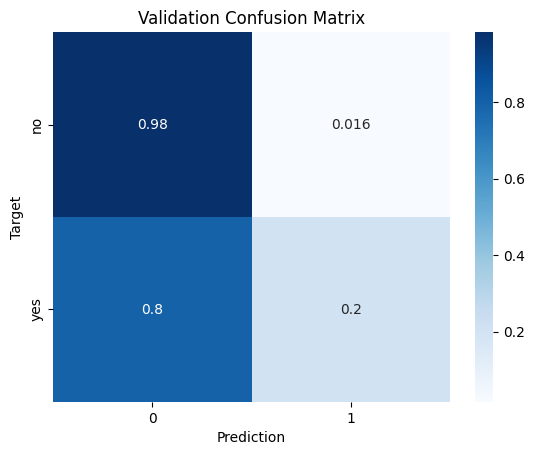


              precision    recall  f1-score   support

           0      0.907     0.984     0.944      7308
           1      0.615     0.205     0.307       928

    accuracy                          0.896      8236
   macro avg      0.761     0.594     0.625      8236
weighted avg      0.874     0.896     0.872      8236



In [42]:
evaluate_predictions(final_lgb_clf, val_inputs, val_targets, 'Validation')

Recommendations:

1. Execution: prioritize cellular campaigns; reserve telephone for segments where it still works.

2. Scheduling: bias contact volume toward months with uplift; A/B test to confirm seasonality.

3. Targeting: re-target past-success customers first; treat “no prior contact” as a neutral-to-positive segment; use default status for gentle prioritization with compliance checks.

4. Validation: confirm these effects hold with time-based CV (guard against temporal drift) and monitor post-deployment since seasonality can shift.